In [11]:
# Jupyterでmatplotlibを使用する宣言と、使用するライブラリの定義
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import display, HTML
%matplotlib inline

In [12]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)

In [13]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
 
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
 
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数

In [14]:
# CartPoleで動くエージェントクラスです、棒付き台車そのものになります
class Agent:
    def __init__(self, num_states, num_actions):
        # 課題の状態と行動の数を設定
        self.num_states = num_states     # CartPoleは状態数4を取得
        self.num_actions = num_actions        # CartPoleの行動（右に左に押す）の2を取得
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための脳を生成
 
    def update_q_function(self, observation, action, reward, observation_next):
        # Q関数の更新
        self.brain.update_Qtable(observation, action, reward, observation_next)
 
    def get_action(self, observation, step):
        # 行動の決定
        action = self.brain.decide_action(observation, step)
        return action

In [15]:
# エージェントが持つ脳となるクラスです、Q学習を実行します
class Brain:
 
    def __init__(self, num_states, num_actions):
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        # 状態を分割数^（4変数）にデジタル変換したQ関数（表）を作成
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**self.num_states, self.num_actions))
 
 
    def bins(self, clip_min, clip_max, num):
        #観測した状態（連続値）を離散値にデジタル変換する
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
 
    def digitize_state(self, observation):
        # 観測したobservation状態を、離散値に変換する
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
        np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
 
    def update_Qtable(self, observation, action, reward, observation_next):
        # QテーブルをQ学習により更新
        # 観測を離散化
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
 
    def decide_action(self, observation, episode):
        # ε-greedy法で徐々に最適行動のみを採用する
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
 
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions) # 0,1の行動をランダムに返す
        return action

In [16]:

# CartPoleを実行する環境のクラスです
class Environment:
 
    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(self.num_states, self.num_actions)  # 環境内で行動するAgentを生成
 
    def run(self):
        # 実行
 
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
 
 
        for episode in range(NUM_EPISODES):
        # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            episode_reward = 0  # エピソードでの報酬
 
            # 1エピソードのループ
            for step in range(MAX_STEPS):
 
                if episode_final is True:
                    # framesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))
 
                action = self.agent.get_action(observation, episode)  # 行動を求める
 
                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, reward_notuse, done, info_notuse = self.env.step(action)
 
                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        self.complete_episodes = 0
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        self.complete_episodes = self.complete_episodes + 1  # 連続記録を更新
                else:
                    reward = 0
 
                episode_reward += reward  # 報酬を追加
 
                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_q_function(
                    observation, action, reward, observation_next)
 
                # 観測の更新
                observation = observation_next
 
                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step+1))
                    break
 
            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break
 
            if self.complete_episodes >= 10:
                print('10回連続成功')
                frames = []
                episode_final = True  # 次の試行を描画を行う最終試行とする

0 Episode: Finished after 11 time steps
1 Episode: Finished after 13 time steps
2 Episode: Finished after 13 time steps
3 Episode: Finished after 10 time steps
4 Episode: Finished after 13 time steps
5 Episode: Finished after 26 time steps
6 Episode: Finished after 16 time steps
7 Episode: Finished after 11 time steps
8 Episode: Finished after 35 time steps
9 Episode: Finished after 10 time steps
10 Episode: Finished after 12 time steps
11 Episode: Finished after 15 time steps
12 Episode: Finished after 11 time steps
13 Episode: Finished after 18 time steps
14 Episode: Finished after 31 time steps
15 Episode: Finished after 29 time steps
16 Episode: Finished after 74 time steps
17 Episode: Finished after 97 time steps
18 Episode: Finished after 26 time steps
19 Episode: Finished after 33 time steps
20 Episode: Finished after 95 time steps
21 Episode: Finished after 74 time steps
22 Episode: Finished after 25 time steps
23 Episode: Finished after 75 time steps
24 Episode: Finished after

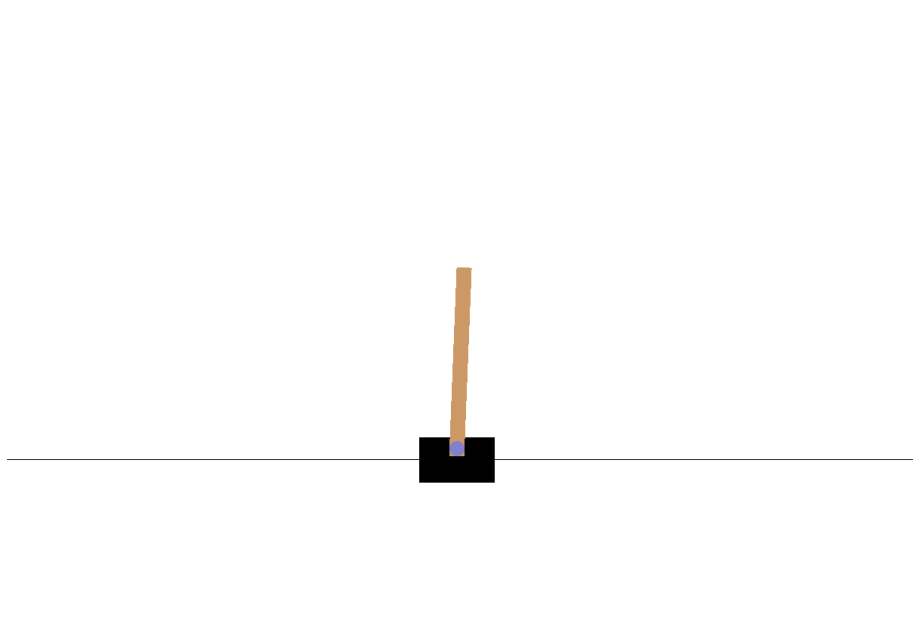

In [17]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()